In [17]:
# predict next day's ACP from previous days' inputs
# v6d: All data entry and manipulation complete
        # Construct model & test
        # Add regularization
        # Add price transform & graphing

# import modules
# import yfinance as yf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

### get the data
df = yf.download('SPY') # loads all data to 'data' 
df[-5:]

raw_data = np.array(df)
raw_data.shape

# data loaded to SPY.txt for further use
outfile = open('SPY.txt', 'w')
for row in range(raw_data.shape[0]):
    for col in range(raw_data.shape[1]):
        outfile.write(str(raw_data[row,col])+' ')
    outfile.write('\n')
outfile.close()

In [18]:
raw_data = np.loadtxt('SPY.txt')
raw_data.shape

(7508, 6)

In [19]:
# this scales all price data to Adjusted Closing Price data (& removes ACP col)
scaled_data = raw_data.copy()
# scale_factor = np.divide(scaled_data[:,4],scaled_data[:,3])
scale_factor = scaled_data[:,4] / scaled_data[:,3]
print(scale_factor.shape)
for i in range(3):
    # scaled_data[:,i] = np.multiply(scaled_data[:,i],scale_factor)
    scaled_data[:,i] = scaled_data[:,i] * scale_factor
scaled_data = np.delete(scaled_data,[3],axis=1)
# print(raw_data[:3])
# print(scaled_data[:3])
print(scaled_data.shape)

(7508,)
(7508, 5)


In [95]:
dropout = 0.3
test_samples = 500          # save last 250 samples (1 year's data) for test data 
train_samples = 3000         # train and validation samples
samples = test_samples + train_samples  # total samples from data set to be used
features = 5                 # data columns representing features
non_features = 0             # data columns to keep data organized
data_step_width = features + non_features  # total # columns in data set
val_split = 0.2
split_point = int(train_samples * (1-val_split))
steps = 32                   # time steps to evaluate
maxConv = 8                  # longest convolution length to evaluate
sample_length = steps + maxConv - 1  # number of time steps needed for each sample     
first_step_idx = -samples - steps - maxConv + 1  # index of 1st datapoint
last_step_idx = -samples   # index representing sample length
print(first_step_idx, last_step_idx)

-3539 -3500


In [96]:
Y_price = scaled_data[-samples:,3]

In [97]:
def normalize(x):              #includes mean & std for pct change
    y_mean = np.mean(x[:,3])
    y_std = np.std(x[:,3])
    x_norm = preprocessing.StandardScaler().fit_transform(x)
    y_value = np.array([x_norm[-1,3], y_mean, y_std])    # returns ACP_norm, y_mean, & y_std to reconstruct ACP
    return x_norm, y_value

In [98]:
# prepare X and Y data samples
X = np.zeros(shape=(samples+1,sample_length,data_step_width))
Y = np.zeros(shape=(samples+1,3))
for i in range(samples+1):
    idxFirst = i + first_step_idx
    idxLast = i + last_step_idx
    X[i,:],Y[i,:] = normalize(scaled_data[idxFirst:idxLast or None])
Y = Y[1:]
X = X[:-1]
print(X.shape, Y.shape)

(3500, 39, 5) (3500, 3)


In [99]:
# divide data into train & test samples
X_train = X[:train_samples]
X_test = X[-test_samples:]
X1_test = X_test[:,-steps:]
X2_test = X_test
print(X.shape, X_train.shape, X_test.shape)

Y_train = Y[:train_samples]
Y_test = Y[-test_samples:]
print(Y.shape, Y_train.shape, Y_test.shape)

(3500, 39, 5) (3000, 39, 5) (500, 39, 5)
(3500, 3) (3000, 3) (500, 3)


#### shows Y value offset by X(ACP) value by 1 timestep
for i in range(-5,0,1):
    print(X[i,-1,3], '|', Y[i])

#### compares reconstructed ACP's with actual ACP's
temp = np.add(np.multiply(Y[:,0], Y[:,2]), Y[:,1])

plt.plot(temp, label='reconstructed ACPs from Y', marker='.')
plt.plot(scaled_data[-samples:,3], label='actual scaled ACPs')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 5)]      0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 39, 5)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 32, 32)       192         ['input_7[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 32, 32)       1312        ['input_8[0][0]']                
                                                                                            

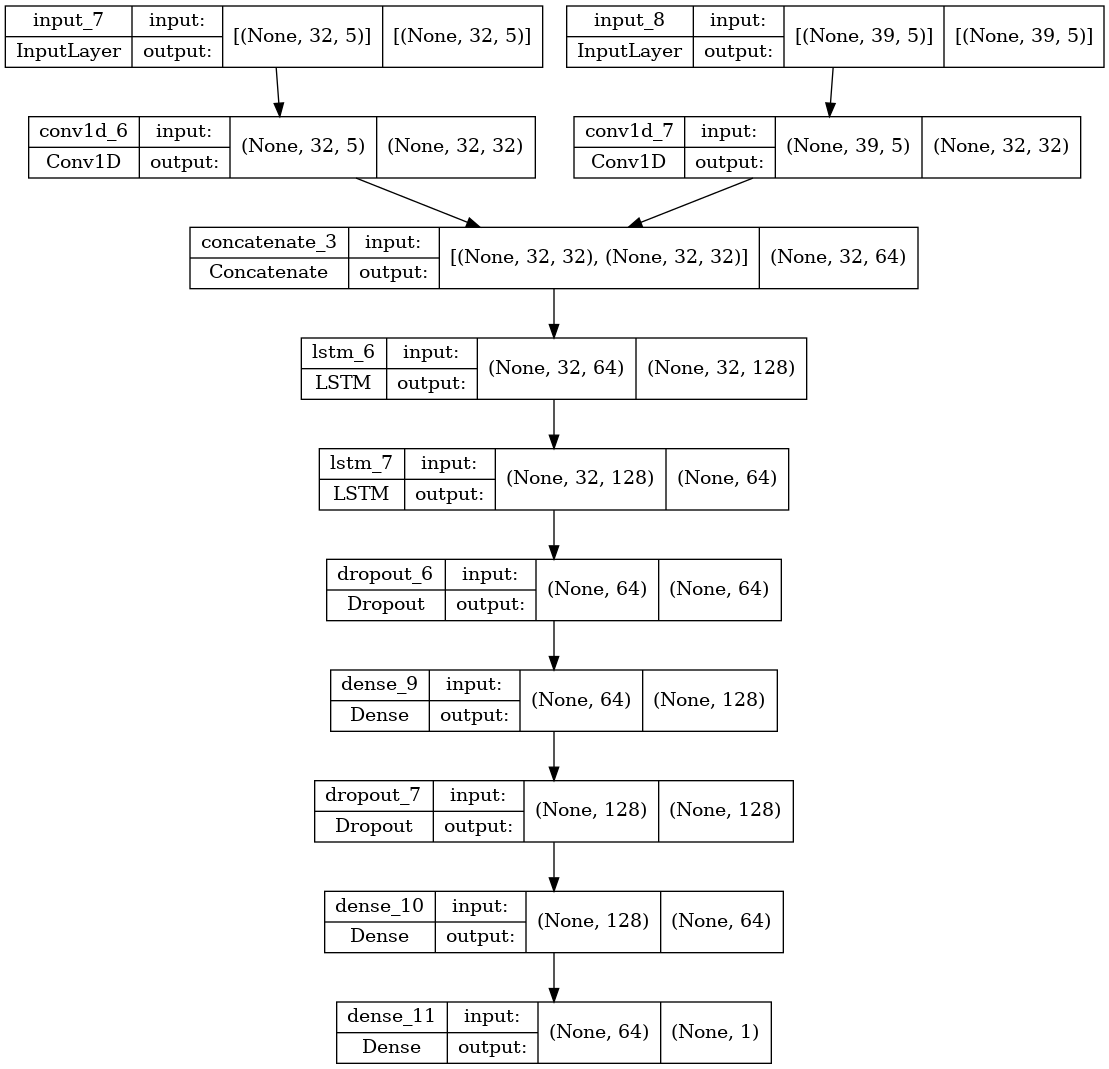

In [100]:
x1 = y1 = keras.layers.Input(shape=(steps,features))
x2 = y2 = keras.layers.Input(shape=X.shape[1:])
x = [x1,x2]

y1 = keras.layers.Conv1D(32,kernel_size=(1),
                        activation='gelu')(x1)
y2 = keras.layers.Conv1D(32,kernel_size=(maxConv),
                        activation='gelu')(x2)
y = keras.layers.Concatenate(axis=2)([y1,y2])   

y = keras.layers.LSTM(128, activation='tanh',
                      dropout = dropout,
                      kernel_regularizer=keras.regularizers.L1L2(l1=0.1,l2=0.1),
                      return_sequences=True,
                      return_state=False)(y)
y = keras.layers.LSTM(64, activation='tanh',
                      dropout = dropout,
                      kernel_regularizer=keras.regularizers.L1L2(l1=0.1,l2=0.1),
                      return_sequences=False,
                      return_state=False)(y)

y = keras.layers.Dropout(dropout)(y)
y = keras.layers.Dense(128,activation='tanh')(y)
y = keras.layers.Dropout(dropout)(y)
y = keras.layers.Dense(64,activation='tanh')(y)
y = keras.layers.Dense(1)(y)

model = keras.Model(x,y)
model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [101]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=keras.metrics.MeanAbsoluteError())

shuffle = np.random.permutation(Y_train.shape[0])
X2_train = X_train
X1_train = X_train[:,-steps:]
X2_shuffle = X_train[shuffle,:]
X1_shuffle = X2_shuffle[:,-steps:]
Y_shuffle = Y_train[shuffle,:]
print(X1_shuffle.shape, X2_shuffle.shape, Y_shuffle.shape)

(3000, 32, 5) (3000, 39, 5) (3000, 3)


print(X2_shuffle[20])
print(X1_shuffle[20])
print(Y_shuffle[:20])

In [102]:
print(model.predict([X1_shuffle[:5],X2_shuffle[:5]]))

[[ 0.08004384]
 [ 0.04476745]
 [ 0.10767087]
 [-0.1469323 ]
 [-0.13841857]]


In [58]:
history = model.fit([X1_shuffle,X2_shuffle], Y_shuffle[:,0],
                    validation_split=0.2,
                    callbacks=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, 
                                                  verbose=1,restore_best_weights=True),
                    epochs=100,
                    verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 103ms/step - loss: 2.2976 - mean_absolute_error: 0.7798 - val_loss: 2.1911 - val_mean_absolute_error: 0.7061
Epoch 2/100
7/7 [==============================] - 1s 93ms/step - loss: 2.4759 - mean_absolute_error: 0.8681 - val_loss: 2.2725 - val_mean_absolute_error: 0.7091
Epoch 3/100
7/7 [==============================] - 1s 93ms/step - loss: 2.4953 - mean_absolute_error: 0.9119 - val_loss: 2.1783 - val_mean_absolute_error: 0.6548
Epoch 4/100
7/7 [==============================] - 1s 94ms/step - loss: 2.4361 - mean_absolute_error: 0.8231 - val_loss: 2.1024 - val_mean_absolute_error: 0.7054
Epoch 5/100
7/7 [==============================] - 1s 98ms/step - loss: 2.2465 - mean_absolute_error: 0.7799 - val_loss: 2.0070 - val_mean_absolute_error: 0.6541
Epoch 6/100
7/7 [==============================] - 1s 95ms/step - loss: 2.1840 - mean_absolute_error: 0.7888 - val_loss: 1.8939 - val_mean_absolute_error: 0.5939
Epoch 7/100
7/7 [==========

In [59]:
model.save("v6d1.h5",save_format='h5')

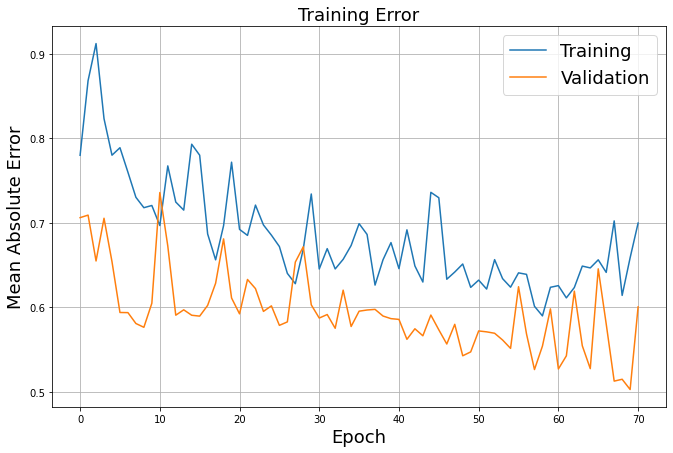

In [288]:
plt.plot(history.history['mean_absolute_error'], label='Training')
plt.plot(history.history['val_mean_absolute_error'], label='Validation')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.legend(fontsize=18)
plt.title('Training Error', fontsize=18)
plt.grid()
plt.show()

# print('Minimum val_mean_absolute_error=', min(history.history['val_mean_absolute_error']))
# print('at Epoch',
#       history.history['val_mean_absolute_error'].index(min(history.history['val_mean_absolute_error']))+1)

In [103]:
model = keras.models.load_model("v6e1d.h5")

In [104]:
Y_predict = model.predict([X1_test,X2_test])
print(Y_predict[-5:], Y_test[-5:,-3])
print(Y_predict.shape, Y_test.shape)

[[0.03040406]
 [1.2000563 ]
 [1.4247519 ]
 [1.0956777 ]
 [1.0470624 ]] [2.01057627 2.13758314 1.74771907 1.5448188  1.58739391]
(500, 1) (500, 3)


In [105]:
Y_predict_price = (Y_predict[:,0] * Y_test[:,-1]) + Y_test[:,-2]
Y_actual_price = (Y_test[:,0] * Y_test[:,-1]) + Y_test[:,-2]
print(Y_predict_price.shape, Y_actual_price.shape)
print(Y_actual_price[-5:])
print(Y_price[-5:])
print(Y_predict_price[-5:])

(500,) (500,)
[395.11999512 398.48999023 395.45001221 394.23999023 396.02999878]
[395.11999512 398.48999023 395.45001221 394.23999023 396.02999878]
[373.95699471 387.8247874  391.61876628 388.75998602 389.28174269]


In [106]:
error = np.zeros(shape=Y_predict.shape)
print(error.shape)
for i in range(Y_predict.shape[0]):    
    error[i] = abs(Y_predict_price[i]-Y_actual_price[i])/Y_actual_price[i]
MAE = np.mean(error)
std = np.std(error)
# print(error[:10])
print('MAE:', MAE)
print('Std Dev:', std)

(500, 1)
MAE: 0.01957561232084558
Std Dev: 0.020889853324603493


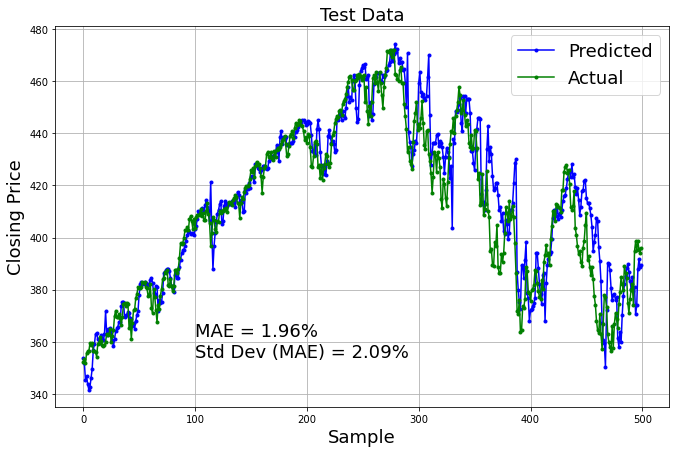

In [110]:
plt.plot(Y_predict_price[:], label='Predicted', color='blue', marker='.')
plt.plot(Y_price[-500:], label='Actual', color='green', marker='.')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend(fontsize=18)
plt.title('Test Data', fontsize=18)
plt.grid()
plt.text(100,362,'MAE = 1.96%', fontsize=18)
plt.text(100,354,'Std Dev (MAE) = 2.09%', fontsize=18)
plt.rcParams['figure.figsize'] = (11,7)
plt.show()

In [79]:
start_point = 0
wins = 0
losses = 0
for i in range(249):
    Y_predict_change = Y_predict[start_point+i+1]-Y_predict[start_point+i]
    Y_actual_change = Y_test[start_point+i+1,0]-Y_test[start_point+i,0]
    if np.sign(Y_predict_change) == np.sign(Y_actual_change):
        wins += 1
    else:
        losses += 1
print('winning trades:', wins, ' losing trades:', losses) 

winning trades: 114  losing trades: 135
MAE: [0.87727606]


In [249]:
Y_train_predict = model.predict([X1_train,X2_train])
print(Y_train_predict[-5:])
Y_train_predict.shape

[[1.96154  ]
 [1.4105319]
 [1.0731993]
 [1.8100753]
 [1.8218448]]


(3000, 1)

In [250]:
Y_train_predict_price = (Y_train_predict[:,0] * Y_train[:,-1]) + Y_train[:,-2]
Y_train_actual_price = (Y_train[:,0] * Y_train[:,-1]) + Y_train[:,-2]
print(Y_train_predict_price.shape, Y_train_actual_price.shape)
print(Y_train_actual_price[:5])
print(Y_price[:5])
print(Y_train_predict_price[:5])

(3000,) (3000,)
[66.79459381 66.60298157 68.18165588 69.15493011 71.23936462]
[66.79459381 66.60298157 68.18165588 69.15493011 71.23936462]
[66.75355681 67.27563407 68.43417741 68.3761639  71.17863352]


In [267]:
i = 1000
n = 25

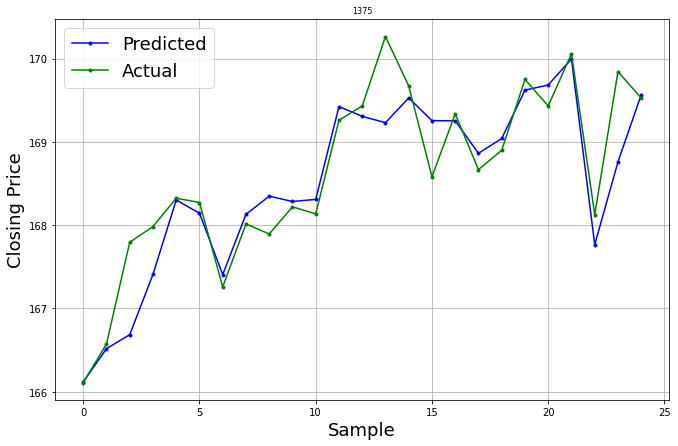

In [283]:
plt.plot(Y_train_predict_price[i:i+n], label='Predicted', color='blue', marker='.')
plt.plot(Y_price[i:i+n], label='Actual', color='green', marker='.')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.grid()
plt.title(i, fontsize=8)
plt.rcParams['figure.figsize'] = (11,7)
plt.show()
i += n